# Target counting using Euler integration

This technique is due to Baryshnikov and Ghrist, and was further explored by Pianini *et alia* who discovered it had more complex error behaviour than anticipated.

In [23]:
from itertools import combinations
import numpy
from numpy.linalg import norm
from numpy.random import rand

from targetcounting import SimpleSensor, drawField, zipboth
from simplicial import SimplicialComplex, EulerIntegrator, TriangularLattice, TriangularLatticeEmbedding
from simplicial.drawing import draw_complex

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt

plt.style.use(['default', 'display.mplstyle'])

## Building the model of overhearing behaviour

The overhearing structure is a simplicial complex with a basis given by the sensors. If two sensors $s_1$ and $s_2$ could observe the same target, meaning that they have overlapping sensor fields, we add a 1-simplex $[s_1, s_2]$ to the complex. Similarly we add a 2-simplex $[s_1, s_2, s_3]$ if there is a third sensor $s_3$ whose sensor field overlaps with those of both $s_1$ and $s_2$, and so on for higher simplices.

In [2]:
class EulerEstimator:
    '''An Euler integral overhearing structure and estimator.

    :param ss: the sensors
    '''

    COUNT = 'count'    #: Attribute  used to hold the count at each sensor simplex.


    def __init__(self, ss):
        self._sensors = ss
        self._c = self._build(ss)


    def _build(self, ss):
        '''Build the overhearing structure for a set of sensors.

        The structure consists of a k-simplex for every set of (k + 1)
        sensors whose sensor fields mutually overlap.

        :param ss: the sensors'''
        c = SimplicialComplex()

        # add the basis, using the sensors' ids as simplex names
        for s in ss:
            c.addSimplex(id=s.id())

        # add higher simplices
        for k in range(1, len(ss)):
            # track now many k-simplices we create
            created = 0

            # run through all combinations of (k + 1) basis simplices
            for pb in combinations(ss, k + 1):
                pairwise = True

                # check all pairwise distances
                for (i, j) in combinations(pb, 2):
                    if not i.isOverlappingWith(j):
                        # pair is not overlapping, so can't create
                        # a k-simplex from this basis
                        pairwise = False
                        break

                # if all the pairwise distances were overlapping,
                # create the higher simplex on this basis
                if pairwise:
                    bs = [s.id() for s in pb]
                    c.addSimplexWithBasis(bs)
                    created += 1

            # if we created enough k-simplices to potentially build
            # a (k + 1)-simplex, carry on; otherwise we can't build any
            # higher simplices, and so can escape from the loop
            if created < (k + 1) + 1:
                break

        # return the overhearing structure
        return c


    def overhearing(self):
        return self._c


The idea behind the Euler integration estimator is to compute the Euler characteristic over successive sub-complexes of the overhearing complex, filtering based on the count at each sensor.

In [3]:
def setCounts(oh, ss, cs):
    '''Apply counts to sensors within the overhearing complex.

    :param oh: the overhearing complex
    :param ss: the sensors
    :param cs: the counts (in the same order as the sensors)'''
    for (s, c) in zipboth(ss, cs):
        oh[s.id()][EulerEstimator.COUNT] = c

We can then get an estimate by integrating the Euler characteristic across the level sets.

In [4]:
def estimate(oh):
    integrator = EulerIntegrator(EulerEstimator.COUNT)
    count = integrator.integrate(oh)
    return count

Let's start with the situation we had before: a sensor field with two targets, one observed by one sensor and one observed by four sensors. The naive estimate of summing-up all the individual counts over-counts the target population.

In [5]:
# placed the sensors in a 5x5 grid
grid = []
d = 0.15
for i in range(5):
    for j in range(5):
        p = [0.1 + (1 / 5) * i, 0.1 + (1 / 5) * j]
        grid.append(SimpleSensor(p, d))

# carefully place the targets
t1 = numpy.array([0.05, 0.05])
t2 = numpy.array([0.2, 0.2])

# count the targets by asking all sensors for their count
cs = []
targets = 0
for s in grid:
    c = s.counts([t1, t2])
    cs.append(c)
    targets += c

print(f'Counting {targets} targets')

Counting 5 targets


Let's now apply the Euler integration method to the same sensors with the same individual counts and see what happens.

In [6]:
# build the overhearing structure
e = EulerEstimator(grid)
oh = e.overhearing()

# set the counts for the sensors
setCounts(oh, grid, cs)

# run the estimator
targets = estimate(oh)

print(f'Counting {targets} targets')

Counting 2 targets


So that worked well! -- the extra topological information about overhearing resolved ther overcounting of ione of the targets and yielded the correct answer.

## Mis-counting

The integrator *can* mis-count, however.

In [18]:
lattice = TriangularLattice(8, 6)
pos = TriangularLatticeEmbedding(lattice, h=0.8, w=0.8)

In [21]:
latticeSensors = []
for i in lattice.simplicesOfOrder(0):
    s = SimpleSensor((pos[i][0] + 0.1, pos[i][1] + 0.1), 0.1, id=i)
    latticeSensors.append(s)

In [38]:
t1 = list(map(lambda p: p[0] + p[1], zipboth(pos[lattice._indexOfVertex(3, 1)], [0.01, -0.01])))
t2 = list(map(lambda p: p[0] + p[1], zipboth(pos[lattice._indexOfVertex(5, 4)], [0.01, -0.01])))

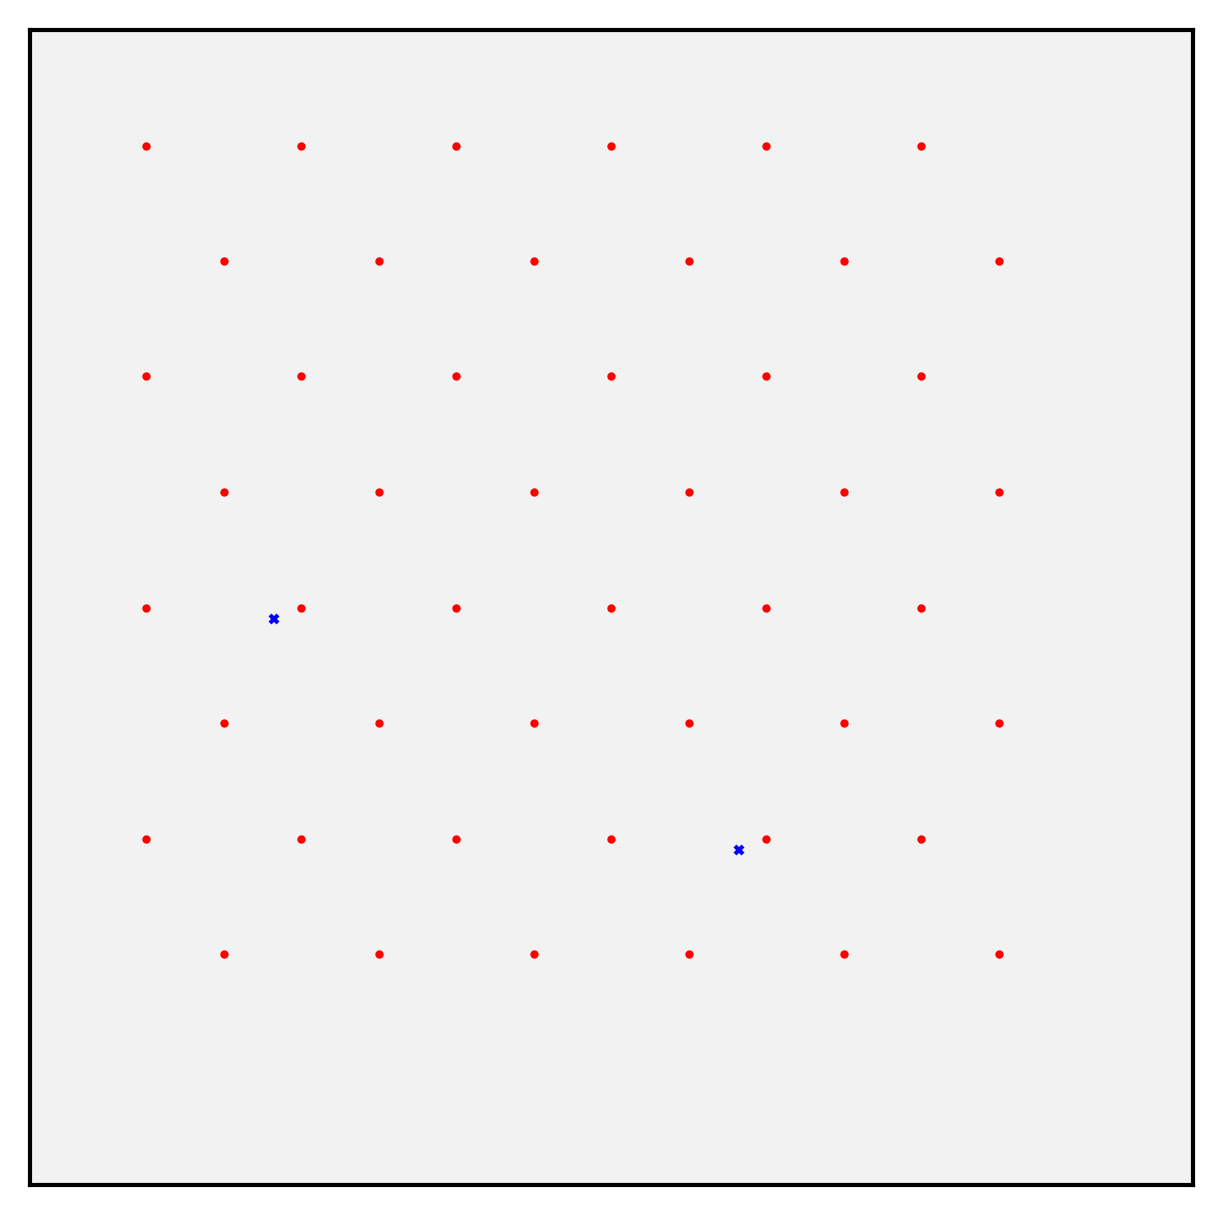

In [39]:
fig = plt.figure()
drawField(latticeSensors, ts=[t1, t2], showFields=False)
plt.show()